# Train CHs segmentation model

In this notebook we will build and run a model training pipeline for CHs segmentation in solar disk images.

Required imports:

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from sunpy.visualization.colormaps import color_tables as ct

sys.path.append("..")
from helio.helio import HelioBatch, FilesIndex, BatchSampler, R, detect_edges, u_net

sdoaia193 = ct.aia_color_table(193)

We will use a dataset of SDO/AIA 193 Angstrom images in 1K resolution obtained at [SunInTime](https://suntoday.lmsal.com/suntoday/) website. Target CHs masks contained in abp 
files were prepared by the [Kislovodsk Mountain Astronomical Station](http://en.solarstation.ru/).

To speed up data loading, solar disk images and abp files are converted to npz file format and resized to 256x256 resolution. For disk images the pipelines is as follows:

In [4]:
images = FilesIndex(img='../../aia193_images/*.jpg')

batch_sampler = BatchSampler(images, batch_size=10, n_epochs=1, shuffle=False, drop_incomplete=False)

for ids in batch_sampler:
    (HelioBatch(ids).load('img', as_gray=True)
     .resize(src='img', output_shape=(256, 256), preserve_range=True)
     .dump('img', path='./tmp/', format='npz'))

For abp files the procedure is similar:

In [6]:
index = FilesIndex(abp='../../aia193/*.abp')

batch_sampler = BatchSampler(index, batch_size=10, n_epochs=1, shuffle=False, drop_incomplete=False)

for ids in batch_sampler:
    (HelioBatch(ids).load('abp', shape=(1024, 1024))
     .resize(src='abp', output_shape=(256, 256), preserve_range=True)
     .dump('abp', path='./tmp/', format='npz'))

Now we index both disk images and target masks and match corresponding files:

In [7]:
img = FilesIndex(image='../../aia193_256/*img.npz')
abp = FilesIndex(mask='../../aia193_256/*abp.npz')
abp.index = abp.index.map(lambda x: x[:15])
img.index = img.index.map(lambda x: x[:15])
index = abp.index_merge(img)
index.head()

,mask,image
FilesIndex,,
20100601_230000,../../aia193_256\20100601_230000_abp.npz,../../aia193_256\20100601_230000_img.npz
20100602_230000,../../aia193_256\20100602_230000_abp.npz,../../aia193_256\20100602_230000_img.npz
20100603_230000,../../aia193_256\20100603_230000_abp.npz,../../aia193_256\20100603_230000_img.npz
20100604_230000,../../aia193_256\20100604_230000_abp.npz,../../aia193_256\20100604_230000_img.npz
20100605_230000,../../aia193_256\20100605_230000_abp.npz,../../aia193_256\20100605_230000_img.npz


An example of source image and contours of target segmentation mask:

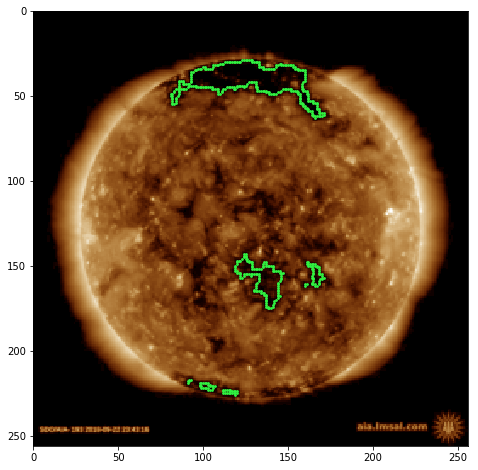

In [8]:
batch = HelioBatch(index.iloc[[3000]]).load(('image', 'mask'))
batch.show(0, image='image', mask='mask', figsize=(8, 8), cmap=sdoaia193, s=3, color='#30f241')

Split the dataset into train and test parts so that all data before 2018 is a train part and everyting starting from 2018 is a test part:

In [9]:
train, test = index.train_test_split(train_ratio=0.7725, suffle=False)
test.head()

,mask,image
FilesIndex,,
20180101_234500,../../aia193_256\20180101_234500_abp.npz,../../aia193_256\20180101_234500_img.npz
20180102_234500,../../aia193_256\20180102_234500_abp.npz,../../aia193_256\20180102_234500_img.npz
20180103_234500,../../aia193_256\20180103_234500_abp.npz,../../aia193_256\20180103_234500_img.npz
20180104_234500,../../aia193_256\20180104_234500_abp.npz,../../aia193_256\20180104_234500_img.npz
20180105_234500,../../aia193_256\20180105_234500_abp.npz,../../aia193_256\20180105_234500_img.npz


Let's biuld a model training pipeline. It consists only of data loading action and several
augmentaion steps that make data more variable:

In [10]:
def preprocess(batch):
    return (batch.load(src=('image', 'mask'))
            .rot90(src=('image', 'mask'), k=R('choice', a=np.arange(4)))
            .flip(src=('image', 'mask'), axis=0, p=R('choice', a=[True, False]))
            .flip(src=('image', 'mask'), axis=1, p=R('choice', a=[True, False]))
           )

Build a CNN model for CHs segmentation:

In [12]:
image_shape = (256, 256, 1)

depth = 4 #Depth of u-net network
init_filters = 24 #Number of filters int the first conv layer

learning_rate = 0.001

config = tf.ConfigProto()
graph = tf.Graph()
with graph.as_default():
    images = tf.placeholder('float', shape=(None, ) + image_shape, name='images')
    masks = tf.placeholder('float', shape=(None, ) + image_shape, name='masks')
    is_training = tf.placeholder(tf.bool, name='is_training')

    predict = u_net(images, depth=depth, init_filters=init_filters,
                    output={'layout': 'ca', 'filters': 1, 'activation': tf.nn.sigmoid},
                    is_training=is_training, verbose=1)
    
    loss = tf.losses.log_loss(masks, predict)

    optimizer = tf.train.AdamOptimizer(learning_rate)
    unet_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        step = optimizer.minimize(loss, var_list=unet_vars)
    
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

Initialize a batch sampler tool. It will generate sets of size ``batch_size`` of random indices from the dataset running the whole dataset ``n_epochs`` times:

In [13]:
batch_sampler = BatchSampler(train, batch_size=20, n_epochs=3, shuffle=True, drop_incomplete=True)

Run model training procedure:

In [14]:
loss_history = []

for ids in tqdm(batch_sampler):
    batch = preprocess(HelioBatch(ids))
    x = np.array([np.atleast_3d(i) for i in batch.image])
    y = np.array([np.atleast_3d(i) for i in batch.mask])
    res = sess.run([loss, step], feed_dict={images: x, masks: y, is_training: True})
    loss_history.append(res[0])

loss_history = np.array(loss_history)

100%|██████████████████████████████████████████████████████████████████████████████| 408/408 [2:15:35<00:00, 19.94s/it]


Plot loss against iterations (first iteration are skipped for better scaling):

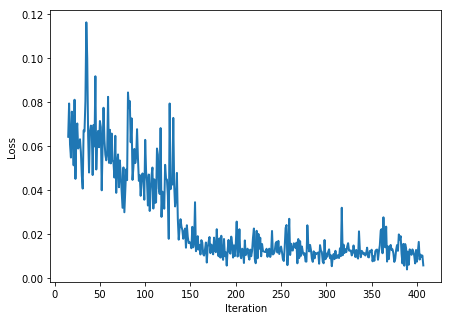

In [15]:
plt.figure(figsize=(7, 5))
skip_iters = 15
plt.plot(np.arange(skip_iters, len(loss_history)), loss_history[skip_iters:], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Evaluate the model on the test part of the dataset. A new batch sampler now runs single time
over each test item:

In [16]:
test_sampler = BatchSampler(test, batch_size=20)

Run the model inferece and dump predicted masks:

In [18]:
for ids in tqdm(test_sampler):
    batch = HelioBatch(ids).load('image')
    x = np.array([np.atleast_3d(i) for i in batch.image])
    res = sess.run(predict, feed_dict={images: x, is_training: False})

    batch.masks = res[..., 0]
    batch.dump(src='masks', path='./masks/', format='npz')

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [03:04<00:00,  4.50s/it]


Merge the dataset of predicted masks with test samples:

In [19]:
test = test.index_merge(FilesIndex(predict='./masks/*.npz'))
test.head()

,mask,image,predict
FilesIndex,,,
20180101_234500,../../aia193_256\20180101_234500_abp.npz,../../aia193_256\20180101_234500_img.npz,./masks\20180101_234500.npz
20180102_234500,../../aia193_256\20180102_234500_abp.npz,../../aia193_256\20180102_234500_img.npz,./masks\20180102_234500.npz
20180103_234500,../../aia193_256\20180103_234500_abp.npz,../../aia193_256\20180103_234500_img.npz,./masks\20180103_234500.npz
20180104_234500,../../aia193_256\20180104_234500_abp.npz,../../aia193_256\20180104_234500_img.npz,./masks\20180104_234500.npz
20180105_234500,../../aia193_256\20180105_234500_abp.npz,../../aia193_256\20180105_234500_img.npz,./masks\20180105_234500.npz


Note that the CNN model actually predicts a score ranging from 0 to 1 for each pixel to be a part of coronal hole. Here is a sample heatmap:

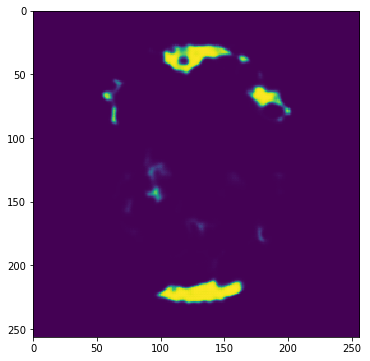

In [20]:
HelioBatch(test.iloc[[0]]).load('predict').show(0, image='predict', figsize=(6, 6))

Next plot shows sample image together with predicted (blue) and target (green) CHs boundaries. CHs boundaries are defined by thresholding the heatmap at 0.5 score level.

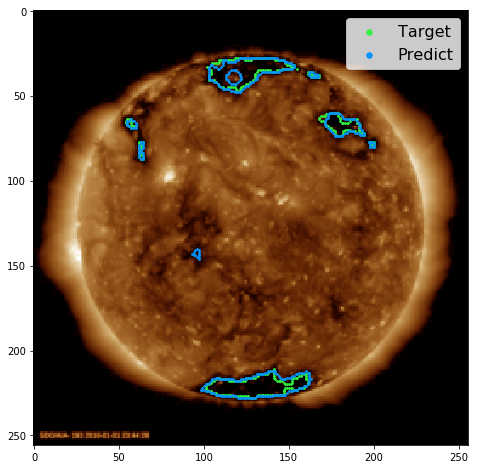

In [26]:
batch = HelioBatch(test.iloc[[0]]).load(('image', 'mask', 'predict'))

plt.figure(figsize=(8, 8))
plt.imshow(batch.image[0], cmap=sdoaia193)
ed = np.where(detect_edges(np.rint(batch.mask[0])) == 1)
plt.scatter(ed[1], ed[0], s=3, color='#30f241', label='Target')
ed = np.where(detect_edges(np.rint(batch.predict[0])) == 1)
plt.scatter(ed[1], ed[0], s=3, color='#0394fc', label='Predict')
lgnd = plt.legend(fontsize=16)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
plt.show()

Save the model:

In [11]:
saver.save(sess, "model_dumps/ch_seg_model.ckpt")

'../model_dumps/ch_seg_model.ckpt'

Done!